In [1]:
import numpy
import cupy
import numpy as np
import cupy as cp
import cmath
import cProfile

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from collections import defaultdict
from typing import Union, Optional, Tuple, Iterable
from numba import jit

import time
import os

%load_ext line_profiler

# Saxpy

We will try to write in backend agnostic manner

In [2]:
def calc_saxpy(alpha: float, x: Union[np.ndarray, cp.ndarray], y: Union[np.ndarray, cp.ndarray]):
    return alpha * x + y

In [3]:
array_lens = np.linspace(10000, 10000000, 30, dtype=int)

In [4]:
cupy_times = []
numpy_times = []
constant = 42

for arr_len in tqdm(array_lens):
    # numpy
    arr_x = np.random.rand(arr_len)
    arr_y = np.random.rand(arr_len)
    
    start = time.time()
    calc_saxpy(constant, arr_x, arr_y)
    numpy_times.append(time.time() - start)
    
    # cupy
    arr_x_gpu = cp.asarray(arr_x)
    arr_y_gpu = cp.asarray(arr_y)
    
    start_gpu = time.time()
    calc_saxpy(constant, arr_x_gpu, arr_y_gpu)
    cupy_times.append(time.time() - start_gpu)

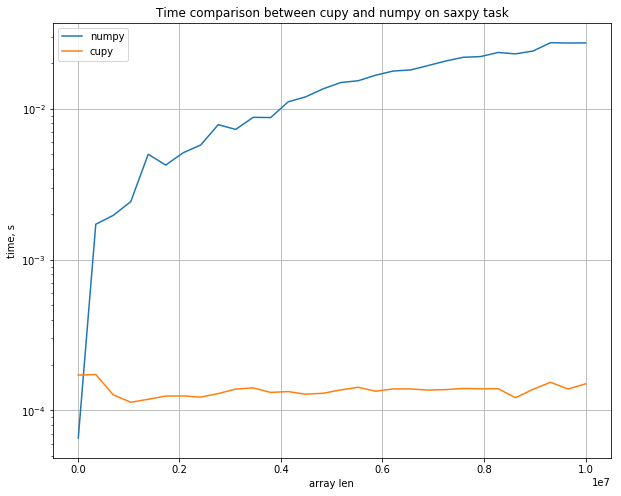

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(array_lens, numpy_times, label='numpy')
ax.plot(array_lens, cupy_times, label='cupy')
ax.set_yscale('log')
ax.grid()
ax.legend()
ax.set_xlabel('array len')
ax.set_ylabel('time, s')
ax.set_title('Time comparison between cupy and numpy on saxpy task')

fig.savefig('saxpy.png')

# Bifurcation map

## Define functions

This version is different from my previous homeworks, but is significantly faster. It is vectorized and requires that number of iterations in experiment and number of Rs is matched.
Otherwise, cupy implementation will be very slow, as it would be sequential on gpu + requiring many send/receives to and from cuda device.

In [5]:
def generate_next_x(x: Union[np.ndarray, cp.ndarray], r: Union[np.ndarray, cp.ndarray]) -> Union[np.ndarray, cp.ndarray]:
    return r * x * (1 - x)


def run_experinemt(
    r: Union[np.ndarray, cp.ndarray],
    x_init: Optional[float] = None,
    n_last_values: int = 200,
    backend: Union['cupy', 'numpy'] = 'numpy'
) -> list:
    
    n_steps = len(r)
    
    if backend == 'cupy':
        xp = cupy
    elif backend == 'numpy':
        xp = numpy
    
    if x_init is None:
        x_init = np.random.random()
    
    xs = xp.ones(n_steps) * x_init
    
    res = []
    for i in range(1, n_steps):
        xs = generate_next_x(xs, r)
        if i > n_steps - n_last_values:
            res.append((r, xs))
        
    return res

## Show that cupy works

In [7]:
n_values = 200

r_values = cp.linspace(0, 4, n_values)
n_last_values = 300

exp_result = run_experinemt(r_values, x_init=None, n_last_values=n_last_values, backend='cupy')

In [228]:
import cProfile

def profile_run():
    run_experinemt(r_values, x_init=None, n_last_values=n_last_values, backend='cupy')
    
cProfile.run('profile_run()')

         40311 function calls in 0.393 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     9999    0.007    0.000    0.024    0.000 <__array_function__ internals>:2(min_scalar_type)
     9999    0.355    0.000    0.379    0.000 <ipython-input-224-bdd2b12276b1>:1(generate_next_x)
        1    0.014    0.014    0.393    0.393 <ipython-input-224-bdd2b12276b1>:5(run_experinemt)
        1    0.000    0.000    0.393    0.393 <ipython-input-228-d2c6ec73044d>:3(profile_run)
        1    0.000    0.000    0.393    0.393 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _generator.py:1263(get_random_state)
        1    0.000    0.000    0.000    0.000 _generator.py:1299(_check_and_get_dtype)
        1    0.000    0.000    0.000    0.000 _generator.py:600(_random_sample_raw)
        1    0.000    0.000    0.000    0.000 _generator.py:610(random_sample)
        1    0.000    0.000    0.000    0.000 _sample.py:141(rand

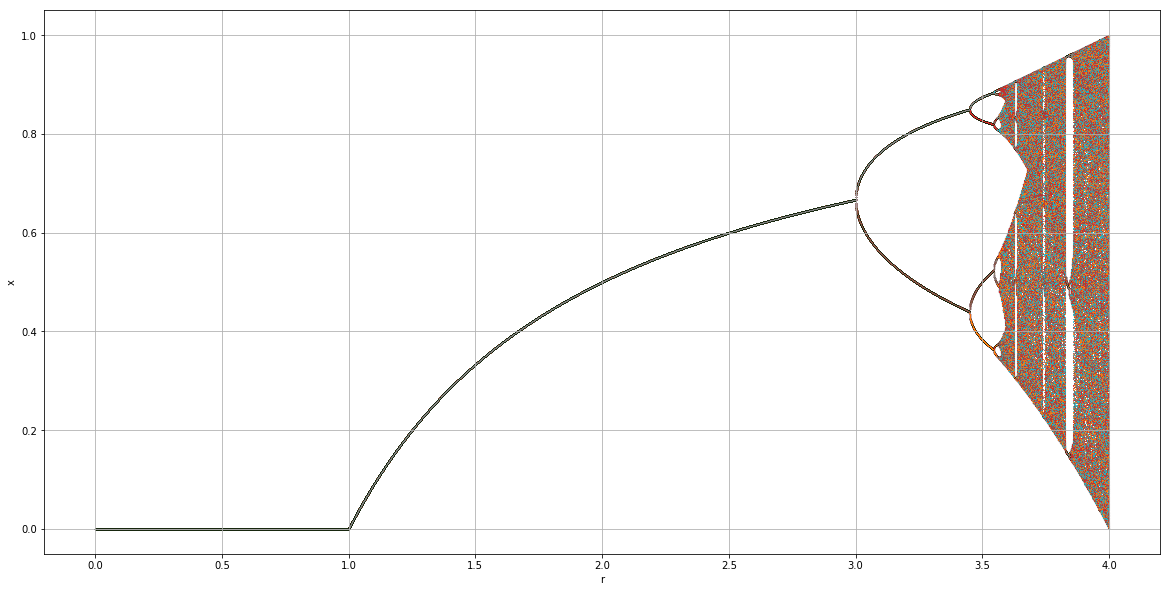

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for r, exp in exp_result:
    try:
        ax.scatter(r, exp, cmap='autumn', marker='.', s=2, linewidths=0.3)
    except TypeError:
        ax.scatter(cp.asnumpy(r), cp.asnumpy(exp), cmap='autumn', marker='.', s=2, linewidths=0.3)

ax.grid()
ax.set_xlabel('r')
ax.set_ylabel('x')

fig.show()

## Calculate times for numpy and cupy implementations

In [8]:
n_last_values = 300

times = defaultdict(list)

n_iterations = np.linspace(2000, 40000, 15, dtype=int)

for backend in ['cupy', 'numpy']:
    print(backend)
    for n_rs in tqdm(n_iterations):
        r_values = np.linspace(0, 4, n_rs)
        if backend == 'cupy':
            r_values = cp.asarray(r_values)
        start = time.time()
        exp_result = run_experinemt(r_values, x_init=None, n_last_values=n_last_values, backend=backend)            
        times[backend].append(time.time() - start)

cupy



numpy


## Get MPI times

In [211]:
if os.path.exists('times'):
    os.remove('times')
    
for n_rs in tqdm(n_iterations):
    os.system(f'mpirun -n 4 python parallel_bifurcation.py --return_time -n_rs={n_rs}')

In [212]:
mpi_times = {}

with open('times', 'r') as f:
    for line in f.readlines():
        iters, t = line.strip().split()
        mpi_times[int(iters)] = float(t)

In [213]:
mpi_times

{2000: 0.0117,
 4714: 0.0309,
 7428: 0.048,
 10142: 0.0932,
 12857: 0.1834,
 15571: 0.2495,
 18285: 0.467,
 21000: 0.5507,
 23714: 0.6905,
 26428: 0.8639,
 29142: 1.0682,
 31857: 1.649,
 34571: 1.7174,
 37285: 1.9291,
 40000: 2.228}

## Plot all times

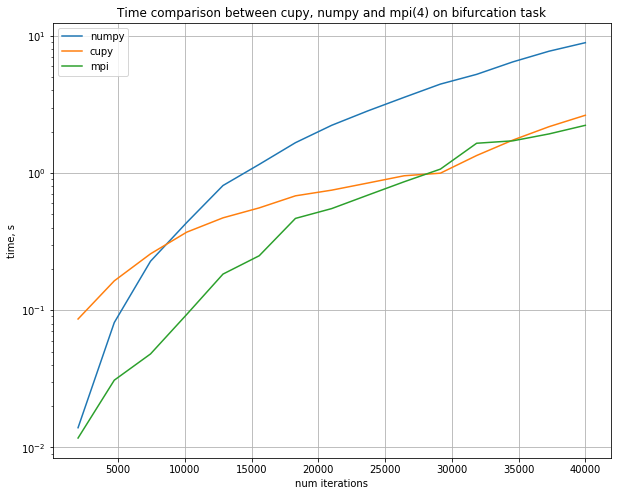

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(n_iterations, times['numpy'], label='numpy')
ax.plot(n_iterations, times['cupy'], label='cupy')
ax.plot(n_iterations, mpi_times.values(), label='mpi')

ax.set_yscale('log')
ax.grid()
ax.legend()
ax.set_xlabel('num iterations')
ax.set_ylabel('time, s')
ax.set_title('Time comparison between cupy, numpy and mpi(4) on bifurcation task')

fig.savefig('bifurcation.png')

# Histogram


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the suggested function:
$$
 f(x) = (z^2(x) + z^3(x) - 200 \,\, z^4(x) )\,\,\sin(\,\,100000\,\,(x + 0.5)\,\,),
 \\
 \text{where    }\:\:\: z(x) = \sin(3\,\,x)-0.5
$$
* Plot function on the $x$ interval $[0,\,\, 1]$. Number of points = 10000000.
* Get minimal and maximal values of function on the interval $[0,\,\, 1]$: $f_{min}$ and $f_{max}$.
* Divide $y=f(x), \: (x \in [0,\,\, 1]) \:$ interval $[f_{min}, f_{max}]$ into $10$ $y=f(x)$ subintervals of length $\delta$ equal to $0.1 \,\, (f_{max}-f_{min})$: $[f_{min},\,\, f_{min} + \delta],\,\, [f_{min}+ \delta,\,\, f_{min} + 2 \,\, \delta],\,\, \dots,\,\, [f_{max}- \delta,\,\, f_{max}]$.
* Compute number of $y=f(x), \: (x \in [0,\,\, 1]) \:$ values in each subinterval. Use $\operatorname{cp.sum(\dots)}$
* Plot histogram. <strong>[Hint: how to represent the histogram](https://cdn.datamentor.io/wp-content/uploads/2017/11/r-histogram.png)</strong>

In [231]:
def calc_z(x: Union[np.ndarray, cp.ndarray], backend: Union['cupy', 'numpy'] = 'numpy'):
    if backend == 'cupy':
        xp = cupy
    elif backend == 'numpy':
        xp = numpy
    
    return xp.sin(3 * x) - 0.5

def calc_f(x: Union[np.ndarray, cp.ndarray], backend: Union['cupy', 'numpy'] = 'numpy'):
    if backend == 'cupy':
        xp = cupy
    elif backend == 'numpy':
        xp = numpy
    
    z_x = calc_z(x, backend=backend)
    z_x_sq = z_x**2
    
    return (z_x_sq + z_x * z_x_sq + z_x_sq**2) * xp.sin(100000 * (x + 0.5)) 

In [391]:
backend = 'cupy'
points = np.linspace(0, 1, 10000000)

if backend == 'cupy':
    points = cp.asarray(points)

res = calc_f(points, backend)

f_min, f_max = np.min(res), np.max(res)
f_min, f_max

(array(-0.43749976), array(0.43749987))

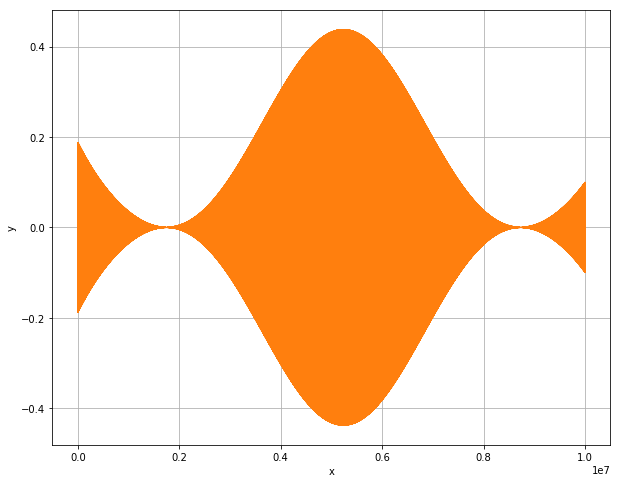

In [384]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

try:
    ax.plot(res)
except TypeError:
    ax.plot(res.get())

ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.savefig('hist_func.png')

In [385]:
n_partitions = 10
step = (f_max - f_min) / n_partitions

In [386]:
curr_min_value = f_min
ticks = []
values = []

xp = cp.get_array_module(res)

for i in tqdm(range(n_partitions)):
    ticks.append(curr_min_value)
    curr_max_value = curr_min_value + step
    values.append(xp.sum((res >= curr_min_value) & (res < curr_max_value)))
    curr_min_value = curr_max_value

ticks.append(f_max)

if backend == 'cupy':
    new_values = [v.get().item() for v in values]
    values = new_values
    
    new_ticks = [v.get().item() for v in ticks]
    ticks = new_ticks

In [387]:
mean_ticks = []
for i in range(len(ticks) - 1):
    mean_ticks.append((ticks[i] + ticks[i + 1]) / 2)

**Time for cupy calculation**

In [388]:
%%time
xp = cp.get_array_module(res)

for i in tqdm(range(n_partitions)):
    ticks.append(curr_min_value)
    curr_max_value = curr_min_value + step
    values.append(xp.sum((res >= curr_min_value) & (res < curr_max_value)))
    curr_min_value = curr_max_value


CPU times: user 36.1 ms, sys: 153 µs, total: 36.2 ms
Wall time: 32.8 ms


**Time for numpy calculation**

In [400]:
backend = 'numpy'
points = np.linspace(0, 1, 10000000)

if backend == 'cupy':
    points = cp.asarray(points)

res = calc_f(points, backend)

f_min, f_max = np.min(res), np.max(res)

n_partitions = 10
step = (f_max - f_min) / n_partitions

In [401]:
%%time

curr_min_value = f_min
ticks = []
values = []
xp = cp.get_array_module(res)

for i in tqdm(range(n_partitions)):
    ticks.append(curr_min_value)
    curr_max_value = curr_min_value + step
    values.append(xp.sum((res >= curr_min_value) & (res < curr_max_value)))
    curr_min_value = curr_max_value

ticks.append(f_max)


CPU times: user 283 ms, sys: 982 µs, total: 283 ms
Wall time: 279 ms


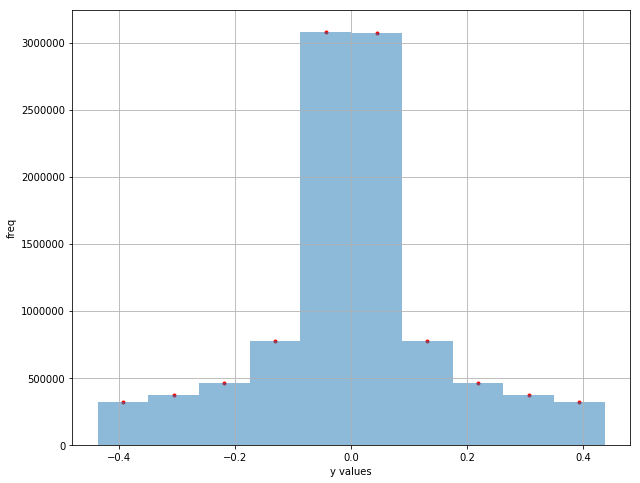

In [402]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

try:
    ax.hist(res, 10, alpha=0.5)
except TypeError:
    ax.hist(res.get(), 10, alpha=0.5)

ax.scatter(mean_ticks, values, marker='.', color='red')
ax.grid()
ax.set_xlabel('y values')
ax.set_ylabel('freq')

fig.savefig('hist.png')

# Image blur


<u>By using <i><strong>CuPy</strong></i>:</u>
Implement the gpu version of the image blur algorithm. What you need to do is calculate convolution some image and some blur filter on every pixel. You should compute convolutions in parallel for every pixel using gpu cores.

In [489]:
blur_filter = np.array([
    [1 / 16, 1 / 8, 1 / 16], 
    [1 / 8, 1 / 4, 1 / 8], 
    [1 / 16, 1 / 8, 1 / 16], 
])

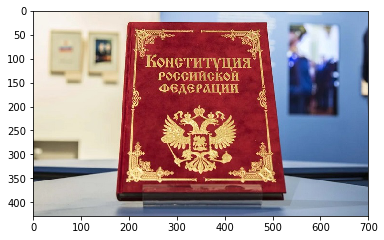

In [490]:
img = plt.imread('constitution.jpg')
plt.imshow(img)

In [564]:
def blur_image(
    img: Union[np.ndarray, cp.ndarray],
    kernel: Union[np.ndarray, cp.ndarray],
):
    xp = cp.get_array_module(img)
    blur_template = xp.zeros_like(img)
    padded_img = xp.stack([xp.pad(img[:, :, c], 1, mode='edge') for c in range(img.shape[2])], axis=-1)
    
    for i in range(blur_template.shape[0]):
        for j in range(blur_template.shape[1]):
            for z in range(blur_template.shape[2]):
                blur_template[i][j][z] = xp.sum(padded_img[i: i + 3, j: j + 3, z] * kernel)
        
    return blur_template

In [565]:
for backend in ['cupy', 'numpy']:
    start = time.time()
    if backend == 'cupy':
        img_gpu = cp.asarray(img)
        blur_filter_gpu = cp.asarray(blur_filter)
        blurred_img_gpu = blur_image(img_gpu, blur_filter_gpu)
    elif backend == 'numpy':
        img_cpu = np.array(img)
        blur_filter_cpu = np.array(blur_filter)
        blurred_img_cpu = blur_image(img_cpu, blur_filter_cpu)
    print(f'{backend} blur executed in {time.time() - start:.2f} seconds')

cupy blur executed in 49.15 seconds
numpy blur executed in 5.86 seconds


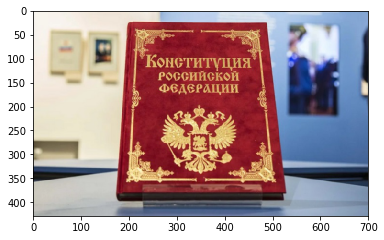

In [566]:
plt.imshow(blurred_img_cpu)

# JIT Mandelbrot

In [6]:
def generate_next_z(z: complex, c: complex=0) -> complex:
    return z ** 2 + c

def run_julia_experiment(z_init: complex, c: complex=0, n_steps: int=100, z_bound: Optional[int] = None):
    z_r = []
    z_i = []
    z = z_init
    
    for i in range(1000):
        if z_bound is not None and cmath.polar(z)[0] > z_bound:
            break
        z = generate_next_z(z, c)
        z_r.append(z.real)
        z_i.append(z.imag)
        
    return z_r, z_i, i

def generate_mandelbrot(imsize: int, n_steps: int, return_image: bool = False):
    z_mod_bound = 2

    res = np.linspace(-1.5, 1.5, imsize)
    ims = np.linspace(-1.5, 1.5, imsize)

    image = np.zeros((imsize, imsize))

    for i, r in enumerate(res):
        for j, im in enumerate(ims): 
            exp_res, exp_ims, stop_iter = run_julia_experiment(0, complex(r, im), n_steps, z_mod_bound)

            image[i][j] = stop_iter / n_steps  # vary brightness by iterations
    
    if return_image:
        return image
    
@jit
def generate_next_z_jitted(z: complex, c: complex=0) -> complex:
    return z ** 2 + c

@jit
def run_julia_experiment_jitted(z_init: complex, c: complex=0, n_steps: int=100, z_bound: Optional[int] = None):
    z_r = []
    z_i = []
    z = z_init
    
    for i in range(1000):
        if z_bound is not None and cmath.polar(z)[0] > z_bound:
            break
        z = generate_next_z_jitted(z, c)
        z_r.append(z.real)
        z_i.append(z.imag)
        
    return z_r, z_i, i

@jit
def generate_mandelbrot_jitted(imsize: int, n_steps: int, return_image: bool = False):
    z_mod_bound = 2

    res = np.linspace(-1.5, 1.5, imsize)
    ims = np.linspace(-1.5, 1.5, imsize)

    image = np.zeros((imsize, imsize))

    for i, r in enumerate(res):
        for j, im in enumerate(ims): 
            exp_res, exp_ims, stop_iter = run_julia_experiment_jitted(0, complex(r, im), n_steps, z_mod_bound)

            image[i][j] = stop_iter / n_steps  # vary brightness by iterations
    
    if return_image:
        return image

In [3]:
%%time
generate_mandelbrot(500, 500)

CPU times: user 22.4 s, sys: 5.39 ms, total: 22.4 s
Wall time: 22.5 s


In [9]:
cProfile.run('generate_mandelbrot(500, 500)')

         172241997 function calls (172241991 primitive calls) in 38.220 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(any)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(linspace)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(ndim)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(result_type)
 42945926    5.069    0.000    5.069    0.000 <ipython-input-6-cc0bdd170cf9>:1(generate_next_z)
        1    0.651    0.651   38.220   38.220 <ipython-input-6-cc0bdd170cf9>:18(generate_mandelbrot)
   250000   22.221    0.000   37.569    0.000 <ipython-input-6-cc0bdd170cf9>:4(run_julia_experiment)
        1    0.000    0.000   38.220   38.220 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 _asarray.py:88(asanyarray)
        2    0.000    0.000  

In [10]:
%%time
generate_mandelbrot_jitted(500, 500)

CPU times: user 2.51 s, sys: 403 ms, total: 2.91 s
Wall time: 2.14 s


Well, we have x10 boost in speed

In [14]:
from matplotlib.ticker import FormatStrFormatter

def plot_julia_image(image: np.ndarray, figsize: Tuple[int]=(10, 10), fontsize: int=12):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    imsize = len(image)
    
    ax.imshow(image, cmap='binary')
    ax.set_xlabel('$\Re(z)$', fontsize=fontsize)
    ax.set_ylabel('$\Im(z)$', fontsize=fontsize)
    ax.set_title('$z_{n+1} = z_n^2 + c$', fontsize=fontsize)

    ticks = np.arange(0, imsize + 100, 100)

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ticks_labels = [f'{tick:.2f}' for tick in np.linspace(-1.5, 1.5, int(imsize / 100) + 1)]

    ax.set_xticklabels(ticks_labels)
    ax.set_yticklabels(ticks_labels)

    return fig

/home/sanityseeker/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


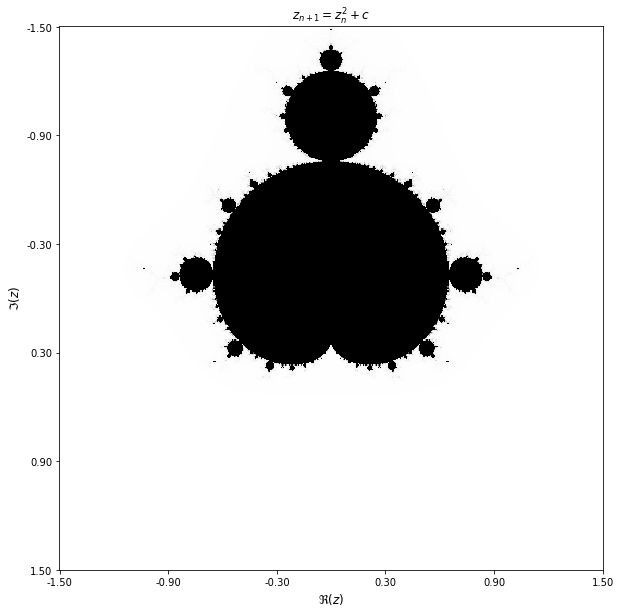

In [15]:
img = generate_mandelbrot_jitted(500, 500)

plot_julia_image(generate_mandelbrot_jitted(500, 500, True), figsize=(14, 11), fontsize=12).show()

In [16]:
orig_func_times = []
jitted_func_times = []

iterations = np.linspace(100, 1000, 5)

for iters in tqdm(iterations):
    start = time.time()
    generate_mandelbrot(500, iters)
    orig_func_times.append(time.time() - start)
    
    start = time.time()
    generate_mandelbrot_jitted(500, iters)
    jitted_func_times.append(time.time() - start)

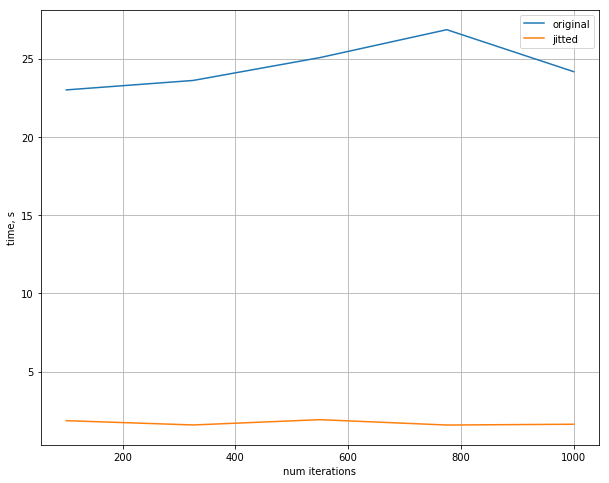

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(iterations, orig_func_times, label='original')
ax.plot(iterations, jitted_func_times, label='jitted')
ax.legend()
ax.grid()
ax.set_xlabel('num iterations')
ax.set_ylabel('time, s')

fig.savefig('jit_mandelbrot.png')

# N-Body problems

Many physical problems require the evaluation of all pairwise interactions of a large number of particles, so-called N-body problems. These problems arise in molecular dynamics, astrodynamics and electromagnetics among others. 

Their pairwise interactions can be expressed as:

\begin{equation}
f_i = \sum_{j=1}^n{P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)w_j} \ \ \ \text{for } i=1,2,...,n 
\end{equation}

*  where subscripts $i$,  $j$ respectively denote *target* and *source*
*  $f_i$ can be a *potential* (or *force*) at target point $i$
*  $w_j$ is the *source weight* 
*  $\boldsymbol{x}_i, \boldsymbol{x}_j$ are the *spatial positions* of particles 
*  $P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)$ is the *interaction kernel*. 

In order to evalute the potential $f_i$ at a target point $i$, we have to loop over each source particle $j$. Since there are $n$ target points $i$, this 'brute-force' approach costs $\mathcal{O} \left(n^2 \right)$ operations. 

One possible approach in this kind of problem is to define a few classes, say `Point` and `Particle` and then loop over the objects and perform the necessary point-to-point calculations.

In [3]:
class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, domain=1.0):
        self.x = domain * numpy.random.random()
        self.y = domain * numpy.random.random()
        self.z = domain * numpy.random.random()
            
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

In [4]:
class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

In [5]:
n = 1000
particles = [Particle(m = 1 / n) for i in range(n)]

In [6]:
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [7]:
direct_sum(particles)

In [8]:
orig_time = %timeit -o direct_sum(particles)

933 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%lprun -f direct_sum direct_sum(particles)

## Use numba to speed up calculations

Numba cannot work with custom classes, but it can with numpy types

In [9]:
particle_dtype = numpy.dtype({'names': ['x', 'y', 'z', 'm', 'phi'],
                              'formats': [numpy.double,
                                          numpy.double,
                                          numpy.double,
                                          numpy.double,
                                          numpy.double]})

### Exercise 1

Write a function `create_n_random_particles` that takes the arguments `n` (number of particles), `m` (mass of every particle) and a domain within to generate a random number (as in the class above).
It should create an array with `n` elements and `dtype=particle_dtype` and then return that array.

For each particle, the mass should be initialized to the value of `m` and the potential `phi` initialized to zero.

For the `x` component of a given particle `p`, you might do something like

```python
p['x'] = domain * numpy.random.random()
```

In [10]:
from numba import njit

@njit
def create_n_random_particles(n: int, m: float, domain: float=1):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    parts = np.zeros((n), dtype=particle_dtype)
        
    for i in range(n):
        parts[i]['x'] = domain * np.random.random()
        parts[i]['y'] = domain * np.random.random()
        parts[i]['z'] = domain * np.random.random()
        
        parts[i]['m'] = m    
    
    return parts

In [11]:
parts = create_n_random_particles(1000, .001, 1)

### Exercise 2

Write a JITted function `distance` to calculate the distance between two particles of dtype `particle_dtype`

Here's the `distance` method from the `Particle` class as a reference:

```python
def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5
```

In [12]:
@njit
def distance_jitted(part1: particle_dtype, part2: particle_dtype):
    '''calculate the distance between two particles'''
    
    return ((part1['x'] - part2['x']) ** 2 + 
            (part1['y'] - part2['y']) ** 2 + 
            (part1['z'] - part2['z']) ** 2) **.5

In [13]:
distance_jitted(parts[0], parts[1])

0.8872534876627108

### Exercise 3
Modify the original `direct_sum` function (copied below for reference) to instead work a NumPy array of particles.  Loop over each element in the array and calculate its total potential.

```python
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r
```

In [14]:
@njit
def direct_sum_jitted(particles: np.ndarray):
    """
    Calculate the potential at each particle
    using direct summation method.
    
    particles: numpy array of particles_dtype
    """
    n = len(particles)
    
    for i in range(n):
        for j in np.arange(0, i):
            r = distance_jitted(particles[i], particles[j])
            particles[i]['phi'] += particles[j]['m'] / r
            
        for j in np.arange(i+1, n):
            r = distance_jitted(particles[i], particles[j])
            particles[i]['phi'] += particles[j]['m'] / r

In [15]:
direct_sum_jitted(parts)

## Compare times

In [21]:
array_lens = np.linspace(1000, 10000, 5, dtype=int)

In [22]:
python_times = []
numba_times = []
domain = 1.0

for arr_len in tqdm(array_lens):
    # python
    particles = [Particle(domain, m=1 / arr_len) for i in range(arr_len)]
    
    start = time.time()
    direct_sum(particles)
    python_times.append(time.time() - start)
    
    # numba
    numba_parts = create_n_random_particles(arr_len, 1 / arr_len, domain)
    
    start_numba = time.time()
    direct_sum_jitted(numba_parts)
    numba_times.append(time.time() - start_numba)

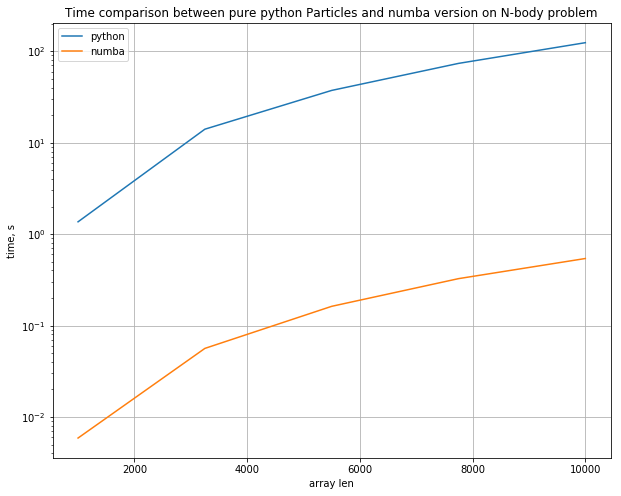

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(array_lens, python_times, label='python')
ax.plot(array_lens, numba_times, label='numba')
ax.set_yscale('log')
ax.grid()
ax.legend()
ax.set_xlabel('array len')
ax.set_ylabel('time, s')
ax.set_title('Time comparison between pure python Particles and numba version on N-body problem')

fig.savefig('numba_particles.png')